# RSI分析

- 观察RSI的变化情况
- 观察上一日close price与多日average price的价差变化情况


价差是均值回归的，与RSI是否存在关联关系？

### 结论：
1. RSI是price diff的放大器，波幅更加剧烈，并且均值回归
2. RSI ≈ Price diff = sec - average，对于RSI<0的情况，要么average变小，要么sec变大
3. 如果是下跌趋势，则average会持续变小，所以是自然变化，如果average在windows范围内有一个反弹，则是比较好的入手时机


** 结论：对于基准下降过程中有反弹，并且价差趋向于上升至0；反之，基准在上升过程中有陡降，并且价差趋向于下降至0；是比较好的入手时机 **

## 步骤1：准备数据

In [1]:
import numpy as np
import pandas as pd

import warnings
# 忽略所有警告
warnings.filterwarnings('ignore')

In [2]:
# plt的默认设置
plt.rcParams['figure.figsize'] = [12.0, 8.0]  # 宽度, 高度

plt.rcParams['axes.spines.right']= False
plt.rcParams['axes.spines.top']= False
plt.rcParams['axes.spines.left']= False
plt.rcParams['axes.spines.bottom']=False

plt.rcParams['axes.labelsize'] = 14  # 设置坐标轴标签字体大小
plt.rcParams['axes.titlesize'] = 16  # 设置标题字体大小
plt.rcParams['xtick.labelsize'] = 12  # 设置x轴刻度标签字体大小
plt.rcParams['ytick.labelsize'] = 12  # 设置y轴刻度标签字体大小
plt.rcParams['grid.alpha'] = 1  # 设置网格透明度

plt.rcParams['axes.grid'] = True # 设置网格线

plt.rcParams['legend.fontsize'] = 16 

plt.rcParams['font.family'] = "monospace" # 设置图片字体

In [3]:
def calculate_rsi(data, period=14):
    """
    计算RSI指标
    :param data: 包含收盘价的Pandas Series或DataFrame
    :param period: RSI计算周期，默认为14天
    :return: 返回RSI值的Pandas Series
    """
    # 计算价格变化
    delta = data.diff()
    
    # 分离正变化和负变化
    gain = delta.copy()
    loss = delta.copy()
    gain[gain < 0] = 0  # 只保留正变化
    loss[loss > 0] = 0  # 只保留负变化（取绝对值）
    loss = abs(loss)
    
    # 计算平均收益和平均损失
    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()
    
    # 计算RS值
    rs = avg_gain / avg_loss
    
    # 计算RSI值
    rsi = 100 - (100 / (1 + rs))
    
    return rsi



In [4]:
# 使用ETF进行研究
# 510050：上证50ETF
# 159919：沪深300ETF
# 510500：中证500
# 512100：中证1000
# 159915：易方达创业板指数

# ETF是一揽子股票，没有相应组成部分，只能从字面上理解相应的组成，通过指数来进行模拟

candidate_ETF = [
    "510050.XSHG",
    "159919.XSHE",
    "510500.XSHG",
    "512100.XSHG",
    "159915.XSHE"
]


# 确定整体时间长度，默认设置为过去500天
ncount = 400

# 确定end_date
end_date='2025-3-28'

In [5]:
# 生成价格pandas数组
price_pd = pd.DataFrame()


for ETF_i in candidate_ETF:
    
    # 初始变量命名
    ETF_i_name = ""
    ETF_i_name = str(ETF_i[:6]) + "_ETF"
    
    # 显示过程
    print(ETF_i_name)

    # 提取价格数据
    price_ETF_temp = pd.DataFrame()
    price_ETF_temp = get_price(ETF_i, count = ncount, end_date=end_date, frequency='daily',fq='pre', fields=['close'])['close']
    price_ETF_temp.name = ETF_i_name

    # 数据合并
    price_pd = pd.concat([price_pd,price_ETF_temp], axis = 1)
    
    
    # 提取成交量数据
    price_ETF_temp = pd.DataFrame()
    price_ETF_temp = get_price(ETF_i, count = ncount, end_date=end_date, frequency='daily', fields=['volume'])['volume']
    price_ETF_temp.name = ETF_i_name+"_Volume"

    # 数据合并
    price_pd = pd.concat([price_pd,price_ETF_temp], axis = 1)




510050_ETF
159919_ETF
510500_ETF
512100_ETF
159915_ETF


In [6]:
price_pd.head()

,510050_ETF,510050_ETF_Volume,159919_ETF,159919_ETF_Volume,510500_ETF,510500_ETF_Volume,512100_ETF,512100_ETF_Volume,159915_ETF,159915_ETF_Volume
2023-08-02,2.602,890529582.0,4.059,255246619.0,5.983,157064774.0,2.570,437982622.0,2.164,406098632.0
2023-08-03,2.626,831193108.0,4.089,177782006.0,6.003,241989280.0,2.572,520223670.0,2.187,445575312.0
2023-08-04,2.628,998877942.0,4.111,316689737.0,6.043,222907547.0,2.587,417079543.0,2.204,886747451.0
2023-08-07,2.617,985794982.0,4.080,308272549.0,6.003,393247790.0,2.575,382969970.0,2.185,595173894.0
2023-08-08,2.613,845949112.0,4.071,210333650.0,5.983,304527836.0,2.564,387717178.0,2.177,526421685.0


## 步骤2：

In [7]:
# 赋值，计算
price_sec = price_pd['159919_ETF']

volume_sec = price_pd['159919_ETF_Volume']

rolling_period = 14

In [8]:
RSI_sec = calculate_rsi(price_sec, period=rolling_period)

RSI_sec.tail(10)

2025-03-17    59.536082
2025-03-18    57.220708
2025-03-19    56.509695
2025-03-20    64.150943
2025-03-21    53.543307
2025-03-24    55.919395
2025-03-25    54.545455
2025-03-26    44.281525
2025-03-27    48.071217
2025-03-28    48.071217
Name: 159919_ETF, dtype: float64

In [9]:
# 计算价差
price_diff = price_sec -  price_sec.rolling(window=rolling_period).mean()
price_diff.tail(10)

2025-03-17    0.062643
2025-03-18    0.070857
2025-03-19    0.072500
2025-03-20    0.030071
2025-03-21   -0.037857
2025-03-24   -0.023214
2025-03-25   -0.022714
2025-03-26   -0.034929
2025-03-27   -0.023000
2025-03-28   -0.038071
Name: 159919_ETF, dtype: float64

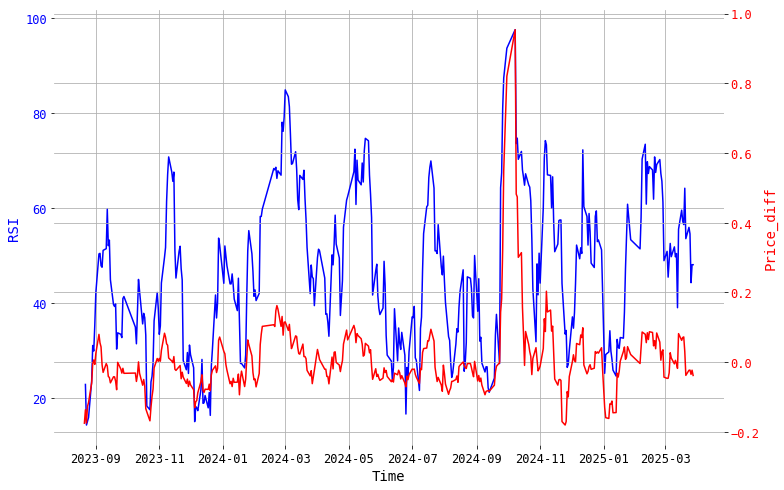

In [10]:
# 创建图形和主坐标轴
fig, ax1 = plt.subplots()

# 绘制主坐标轴的曲线
ax1.plot(RSI_sec.index, RSI_sec, 'b-', label='RSI')  # 主坐标轴颜色为蓝色
ax1.set_xlabel('Time')
ax1.set_ylabel('RSI', color='b')  # 主坐标轴的 Y 轴标签
ax1.tick_params(axis='y', labelcolor='b')  # 设置主坐标轴的 Y 轴刻度颜色


# 添加次坐标轴
ax2 = ax1.twinx()  # 创建共享 X 轴的次坐标轴
ax2.plot(price_diff.index,price_diff, 'r-', label='Price_diff')  # 次坐标轴颜色为红色
ax2.set_ylabel('Price_diff', color='r')  # 次坐标轴的 Y 轴标签
ax2.tick_params(axis='y', labelcolor='r')  # 设置次坐标轴的 Y 轴刻度颜色

# 添加图例
# fig.tight_layout()  # 自动调整布局
# fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))  # 统一图例位置

# 显示图形
plt.show()

## 步骤3：观测近期数据

In [11]:
# 观测窗口长度
Observe_window = 100

In [12]:
RSI_sec_observe = RSI_sec[-Observe_window:]
price_diff_observe = price_diff[-Observe_window:]

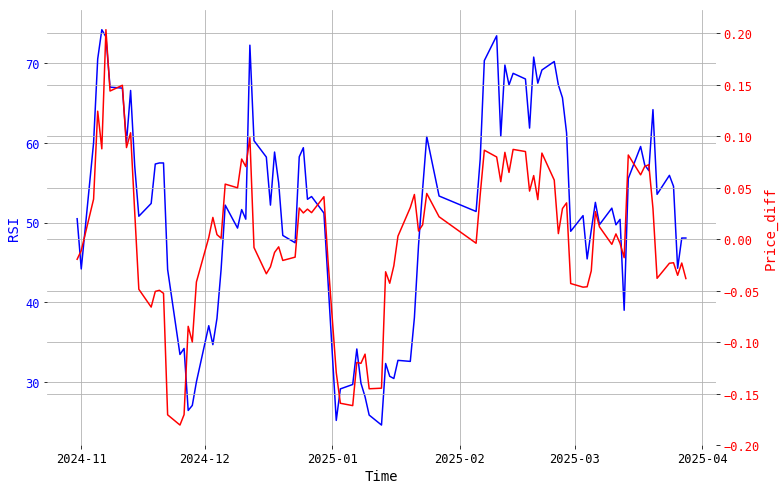

In [13]:
# 创建图形和主坐标轴
fig, ax1 = plt.subplots()

# 绘制主坐标轴的曲线
ax1.plot(RSI_sec_observe.index, RSI_sec_observe, 'b-', label='RSI')  # 主坐标轴颜色为蓝色
ax1.set_xlabel('Time')
ax1.set_ylabel('RSI', color='b')  # 主坐标轴的 Y 轴标签
ax1.tick_params(axis='y', labelcolor='b')  # 设置主坐标轴的 Y 轴刻度颜色


# 添加次坐标轴
ax2 = ax1.twinx()  # 创建共享 X 轴的次坐标轴
ax2.plot(price_diff_observe.index,price_diff_observe, 'r-', label='Price_diff')  # 次坐标轴颜色为红色
ax2.set_ylabel('Price_diff', color='r')  # 次坐标轴的 Y 轴标签
ax2.tick_params(axis='y', labelcolor='r')  # 设置次坐标轴的 Y 轴刻度颜色

# 添加图例
# fig.tight_layout()  # 自动调整布局
# fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))  # 统一图例位置

# 显示图形
plt.show()

### 小结

实际RSI和Price Differences是高度同步的变量，不管从周期还是波动时间点

相对来说RSI的振幅更高一点，有放大的作用

## 步骤4：观测成交量数据

In [14]:
# 计算价差
volume_diff = volume_sec -  volume_sec.rolling(window=rolling_period).mean()
volume_diff.tail(10)

2025-03-17    3.268290e+07
2025-03-18   -5.809622e+07
2025-03-19   -4.511828e+07
2025-03-20   -1.800819e+07
2025-03-21    5.235398e+06
2025-03-24   -8.664965e+07
2025-03-25   -1.205007e+08
2025-03-26   -9.784988e+07
2025-03-27   -9.065467e+07
2025-03-28   -7.134509e+07
Name: 159919_ETF_Volume, dtype: float64

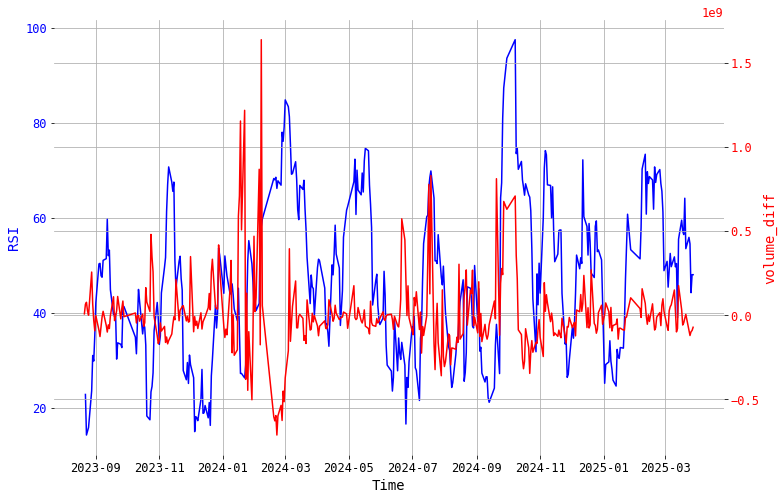

In [15]:
# 创建图形和主坐标轴
fig, ax1 = plt.subplots()

# 绘制主坐标轴的曲线
ax1.plot(RSI_sec.index, RSI_sec, 'b-', label='RSI')  # 主坐标轴颜色为蓝色
ax1.set_xlabel('Time')
ax1.set_ylabel('RSI', color='b')  # 主坐标轴的 Y 轴标签
ax1.tick_params(axis='y', labelcolor='b')  # 设置主坐标轴的 Y 轴刻度颜色


# 添加次坐标轴
ax2 = ax1.twinx()  # 创建共享 X 轴的次坐标轴
ax2.plot(volume_diff.index,volume_diff, 'r-', label='volume_diff')  # 次坐标轴颜色为红色
ax2.set_ylabel('volume_diff', color='r')  # 次坐标轴的 Y 轴标签
ax2.tick_params(axis='y', labelcolor='r')  # 设置次坐标轴的 Y 轴刻度颜色

# 添加图例
# fig.tight_layout()  # 自动调整布局
# fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))  # 统一图例位置

# 显示图形
plt.show()

In [16]:
RSI_sec_observe = RSI_sec[-Observe_window:]
volume_diff_observe = volume_diff[-Observe_window:]

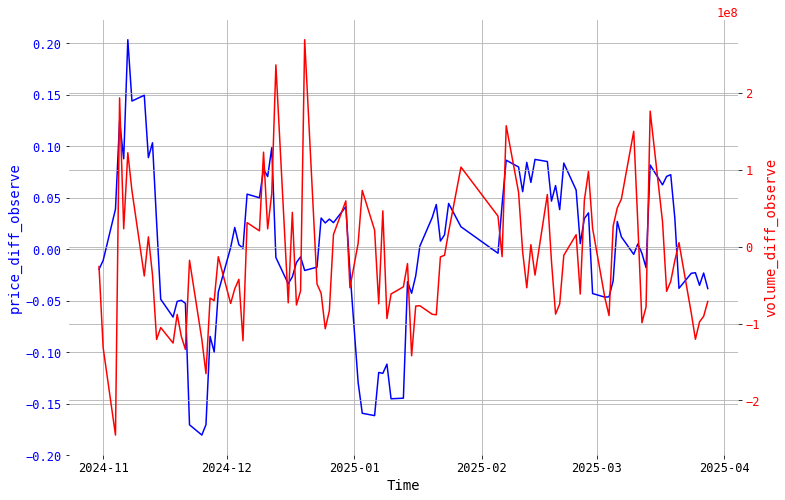

In [17]:
# 创建图形和主坐标轴
fig, ax1 = plt.subplots()

# 绘制主坐标轴的曲线
ax1.plot(price_diff_observe.index, price_diff_observe, 'b-', label='price_diff_observe')  # 主坐标轴颜色为蓝色
ax1.set_xlabel('Time')
ax1.set_ylabel('price_diff_observe', color='b')  # 主坐标轴的 Y 轴标签
ax1.tick_params(axis='y', labelcolor='b')  # 设置主坐标轴的 Y 轴刻度颜色


# 添加次坐标轴
ax2 = ax1.twinx()  # 创建共享 X 轴的次坐标轴
ax2.plot(volume_diff_observe.index,volume_diff_observe, 'r-', label='volume_diff_observe')  # 次坐标轴颜色为红色
ax2.set_ylabel('volume_diff_observe', color='r')  # 次坐标轴的 Y 轴标签
ax2.tick_params(axis='y', labelcolor='r')  # 设置次坐标轴的 Y 轴刻度颜色

# 添加图例
# fig.tight_layout()  # 自动调整布局
# fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))  # 统一图例位置

# 显示图形
plt.show()

In [18]:
# 研究成交量和价差变化不同步的位置

data_change_pd = pd.concat([price_diff,volume_diff],axis=1)

data_change_pd.columns = ['price','volume']

data_change_pd = data_change_pd.fillna(0)

data_change_pd.head()

,price,volume
2023-08-02,0.0,0.0
2023-08-03,0.0,0.0
2023-08-04,0.0,0.0
2023-08-07,0.0,0.0
2023-08-08,0.0,0.0


In [19]:
data_change_pd['price'] = data_change_pd['price'] > 0
data_change_pd['volume'] = data_change_pd['volume'] > 0

In [20]:
# 四个状态
# State：1，价格涨，成交量涨
# State：2，价格跌，成交量涨
# State：3，价格涨，成交量跌
# State：4，价格跌，成交量跌

data_change_pd.loc[(data_change_pd['price'] == True) & (data_change_pd['volume'] == True),'State'] =1

data_change_pd.loc[(data_change_pd['price'] == False) & (data_change_pd['volume'] == True),'State'] =2

data_change_pd.loc[(data_change_pd['price'] == True) & (data_change_pd['volume'] == False),'State'] =3

data_change_pd.loc[(data_change_pd['price'] == False) & (data_change_pd['volume'] == False),'State'] =4


Text(0, 0.5, 'Price')

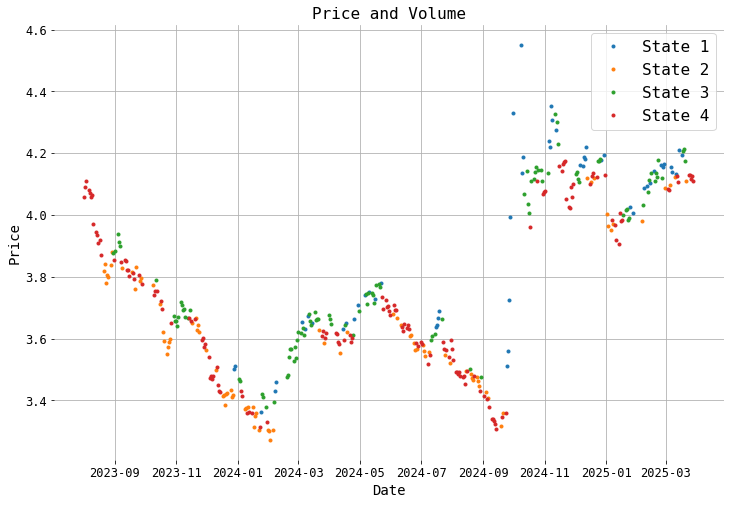

In [21]:
for i in range(1,5):
    state_flag = (data_change_pd['State'] == i)
    
    plt.plot(price_sec.index[state_flag], price_sec[state_flag],'.',label=f'State {i}',lw=1.5)
    

plt.legend()
plt.title('Price and Volume')
plt.xlabel('Date')
plt.ylabel('Price')
